In [17]:
import pyaudio
import wave
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import random

from scipy.io.wavfile import read
import scipy

from random import random
import math
from numpy.linalg import inv
from scipy.linalg import toeplitz

import wave, os, glob

from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator as pchip

import librosa

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from pycm import *
from sklearn.svm import SVC

import time

In [41]:
from python_speech_features import mfcc
from python_speech_features import logfbank
from python_speech_features.sigproc import preemphasis
from python_speech_features.base import delta
from python_speech_features.base import fbank
from python_speech_features.sigproc import framesig

from termcolor import colored

### EMODB DATASET DESCRIPTION

1. 6 basics emotions- W-anger, L-boredom, E-disgust, A-anxiety, F-happiness, T-sadness, N-neutral

2. 5F, 5M (10 utterences, 5 short & 5 longer)

3. filename = 03a01Fa.wav --> 03-a01-F-a.wav
              03--> speaker detail(M,31 year old) others are [08,09,10,11,12,13,14,15,16]
              a01--> code for text
              F--> emotion code
              a--> if there are more than 2 versions (there are no. a,b,c...)

In [4]:
# fixed points taken for spline interpolation
xv=[0,0.35,0.69,1]    

# FIXED PARAMETER FOR endSPLINE 2
r_1=np.random.rand(4)
x2_fixed =np.sort(r_1)
x2_fixed=x2_fixed.tolist()

x2_fixed.insert(0,0.02)
x2_fixed.insert(5,1)

x2_modified=np.asarray(x2_fixed)

total_fbank=30
nf=26

# nf equidistant point in between 0 & 1
xx=np.linspace(0,1,nf+2)              # will replace xx_full

yv=np.zeros((total_fbank,4))                 # initialising y values for spline 1
y2_rand=np.zeros((total_fbank,4))            # initialising y values for spline 2

sigma=np.zeros(total_fbank)           # 1-D arrray
rho=np.zeros(total_fbank)

EA_population=np.zeros((total_fbank,8))           # random EA population


In [5]:
for fb in range (total_fbank):                               # total_filterbank
       
    #PARAMETER INITIALIZATION FOR SPLINE 1   
    a=0.1                                            #parameter to limit range of spline in bet. 0 & 1   
    y1=a+random()*(1-2*a)
    delta=random()*(1-a-y1)
    y2=y1+delta
    
    yv[fb][:]=[0,y1,y2,1]
    
    # 1st derivative calculation at end points
    s1 = xv[0]-xv[1]         # sigma is the 1st derivative at x=0,y=0
    s2 = xv[0]-xv[2]
    s3 = xv[0]-xv[3]
    s12 = s1-s2
    s13 = s1-s3 
    s23 = s2-s3
    sigma[fb]=-(s1*s2/(s13*s23*s3))*yv[fb][3]+(s1*s3/(s12*s2*s23))*yv[fb][2]-(s2*s3/(s1*s12*s13))*yv[fb][1]+(1./s1+1./s2+1./s3)*yv[fb][0]
    
    s11 = xv[3]-xv[2]         #rho is the 1st derivative at x=1,y=1
    s22 = xv[3]-xv[1]
    s33 = xv[3]-xv[0]
    s_12 = s11-s22 
    s_13 = s11-s33 
    s_23 = s22-s33
    rho[fb]=-(s11*s22/(s_13*s_23*s33))*yv[fb][0]+(s11*s33/(s_12*s22*s_23))*yv[fb][1]-(s22*s33/(s11*s_12*s_13))*yv[fb][2]+(1./s11+1./s22+1./s33)*yv[fb][3]
    
    # PARAMETER INTIALIZATION FOR SPLINE 2
    y2_rand[fb,:]= np.random.rand(4)
    
    #cc=[y1, delta, sigma[0,fb], rho[0,fb]]+ y2_rand[fb,:].tolist()
    EA_population[fb,:]=[y1, delta, sigma[fb], rho[fb]]+ y2_rand[fb,:].tolist()


In [8]:
## SPLITTING TRAINING & TESTING DATASET 

fs=8000

X_data = []
Y_data = []

X_test = []
Y_test = []

path = 'C:/emodb_new/wav'
for filename in glob.glob(os.path.join(path, '*.wav')):
    
    samplerate, data = scipy.io.wavfile.read(filename,mmap=False)
    
    # selecting speaker 15 & 16 for testing dataset
    
    if(filename[17:19]=='15' or filename[17:19]=='16'):
        X_test.append(data)
        if (filename[22]=='W'):
            Y_test.append(0)  
        elif(filename[22]=='L'):
            Y_test.append(1)
        elif(filename[22]=='E'):
            Y_test.append(2)
        elif(filename[22]=='A'):
            Y_test.append(3)
        elif(filename[22]=='F'):
            Y_test.append(4)
        elif(filename[22]=='T'):
            Y_test.append(5)
        else:                                #(filename[22]=='N')
            Y_test.append(6)
    else:
        X_data.append(data)
        if (filename[22]=='W'):
            Y_data.append(0)  
        elif(filename[22]=='L'):
            Y_data.append(1)
        elif(filename[22]=='E'):
            Y_data.append(2)
        elif(filename[22]=='A'):
            Y_data.append(3)
        elif(filename[22]=='F'):
            Y_data.append(4)
        elif(filename[22]=='T'):
            Y_data.append(5)
        else:                                #(filename[22]=='N')
            Y_data.append(6)
        

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [39]:
fs=8000

X_all = []
Y_all = []

path = 'C:/emodb_new/wav'
for filename in glob.glob(os.path.join(path, '*.wav')):
    
    samplerate, data = scipy.io.wavfile.read(filename,mmap=False)
    dt =  data/max(data)
    X_all.append(dt)
    if (filename[22]=='W'):
        Y_all.append(0)  
    elif(filename[22]=='L'):
        Y_all.append(1)
    elif(filename[22]=='E'):
        Y_all.append(2)
    elif(filename[22]=='A'):
        Y_all.append(3)
    elif(filename[22]=='F'):
        Y_all.append(4)
    elif(filename[22]=='T'):
        Y_all.append(5)
    else:                                #(filename[22]=='N')
        Y_all.append(6)
        
X_pre_emp = []
N_all = len(X_all)

for i in range(N_all):
    X_pre_emp.append(preemphasis(X_all[i], coeff=0.94))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [33]:
X_all

[array([ 22, 101,  83, ..., -76, -61, -61], dtype=int16),
 array([ 9,  3, 13, ..., -3, -7, -1], dtype=int16),
 array([  0,   1,  -5, ..., -13, -15,  -5], dtype=int16),
 array([23, 82, 88, ...,  8,  5,  0], dtype=int16),
 array([  2, -10,  -5, ...,   7,   2,  -2], dtype=int16),
 array([0, 0, 7, ..., 7, 7, 0], dtype=int16),
 array([ 87, 105, 135, ...,  25,  25,  25], dtype=int16),
 array([  3,   4,   2, ..., -15, -13, -13], dtype=int16),
 array([  5, -52, -30, ...,   2,   0,  -2], dtype=int16),
 array([ 1, -3, -9, ...,  1,  4,  0], dtype=int16),
 array([ 46,  46,  53, ..., -70, -65, -60], dtype=int16),
 array([  0,   0,   0, ..., -22, -10, -21], dtype=int16),
 array([13, 13, 13, ...,  0, 13,  0], dtype=int16),
 array([ 0, 17, 27, ...,  1,  0, -2], dtype=int16),
 array([  0,   8,   8, ..., -61, -42,  -5], dtype=int16),
 array([80, 67, 92, ..., 76, 71, 67], dtype=int16),
 array([-115, -112, -115, ...,   -6,   -9,   -2], dtype=int16),
 array([  7, -23,   0, ..., -38, -30, -23], dtype=int16)

for this error RuntimeWarning: invalid value encountered in double_scalars, import orderedDict

In [29]:
t1 = time.perf_counter()

from collections import OrderedDict
old_settings = np.seterr(all='print')
OrderedDict(np.geterr())

gen = 2                                       # no. of generation
valid_accuracy = np.zeros((total_fbank,gen))
g = 0

N_data=len(X_data)
N_test=len(X_test)

feat_size=42
 
X_set=np.zeros((N_data,feat_size))

#X_train=zeros(N_train, feat_size) 
#X_valid= zeros(N_valid,feat_size)

#emo_accuracy=zeros(7,gen);
#emo_train=zeros(7,gen);
#emo_valid=zeros(7,gen);

while(g<gen):
    
    for fb in range (total_fbank):                                           # fb=1:total_fbank
        
        # formation of spline 1
        y_spline1 = splineinterpolation(xv,yv[fb][:],EA_population[fb][2], EA_population[fb][3])  


        #plot(xx_mod,y_spline1)  

        y_min= min(y_spline1)                      
        y_max= max(y_spline1)

        ## OPTIMAIZATION OF FITER FREQ. LOCATION 

        freq=np.zeros(nf+1)
        for i in range (nf+1):                                   # i = 1:nf+1                            
            freq[i] = (y_spline1[i]-y_min)*fs/(2*(y_max-y_min))

        freq=np.sort(freq)

        ## OPTIMIZATION OF FILTER AMPLITUDE

        y2_modified = [0.2]+ y2_rand[fb,:].tolist()+[1]
        cs = pchip(x2_modified, y2_modified)
        y_spline2=cs(xx)               # xx consists nf+2 pts. including end points

        #plt.plot(x2_modified, y2_modified, 'o', label='data')
        #plt.plot(xx, cs(xx), label="S")

        maxi=0
        for i in range(nf-1):                                     #i=1:nf-1
            t=np.absolute(freq[i+2]-freq[i])
            if(t > maxi):
                maxi=t

        N=256
        col=math.ceil(maxi*N/fs)+10
        filters=np.zeros((26,col))

        BW=np.zeros(nf)
        for i in range (nf):                                         # i=1:nf
            BW[i]=6.23*pow(freq[i]/1000,2)+93.39*(freq[i]/1000)+28.52

        for i in range (nf):                                               # i=1:nf
            yline1=[]
            yline2=[]

            ff1=freq[i]-BW[i]/2
            ff2=freq[i]+BW[i]/2
            if(ff1>0):
                f1=np.arange(ff1,freq[i]+1,fs/N)                             #ff1:fs/N:freq(i)
            else:
                f1=np.arange(0,freq[i]+1,fs/N)                              #0:fs/N:freq[i]

            if(ff2>(fs/2)):
                f2=np.arange(freq[i],(fs/2)+1,fs/N)                         #freq(i):fs/N:(fs/2);
                freq_inter=np.intersect1d(f2,fs/2)
                if(len(freq_inter)==0):
                    f2=np.append(f2,fs/2)

            else:
                f2=np.arange(freq[i],ff2+1,fs/N)                                      #freq(i):fs/N:ff2;
                freq_inter=np.intersect1d(f2,ff2)
                if(len(freq_inter)==0):
                    f2=np.append(f2,ff2)


            if(freq[i]==0 or freq[i]==fs/2):
                if(freq[i]==0):
                    yline1.append(np.array([0]))
                    yline2.append(-y_spline2[i]*(f2-ff2)/(ff2-freq[i]))
                else:
                    yline1.append(-y_spline2[i]*(f1-ff1)/(ff1-freq[i]))
                    yline2.append(np.array([0]))

            elif(ff1<0 and freq[i]!=0 and ff2 <= fs/2 ):
                yline1.append(y_spline2[i]*f1/freq[i])
                yline2.append(-y_spline2[i]*(f2-ff2)/(ff2-freq[i]))

            elif(ff2 > (fs/2) and freq[i] < (fs/2) and ff1>0):
                yline1.append(-y_spline2[i]*(f1-ff1)/(ff1-freq[i]))
                yline2.append(-y_spline2[i]*(f2-(fs/2))/((fs/2)-freq[i]))
            else:
                yline1.append(-y_spline2[i]*(f1-ff1)/(ff1-freq[i]))
                yline2.append(-y_spline2[i]*(f2-ff2)/(ff2-freq[i]))


            L1=yline1[0].tolist()
            L2=yline2[0].tolist()
            yline= L1+L2

            k_len=len(yline)
            f_final=np.append(f1,f2)
            filters[i,0:k_len]=yline

            #plt.plot(f_final,filters[i,0:k_len])             # filters(i,1:k_len)


        #plt.plot(freq ,y_spline2[0:-1])                  # y_spline2(1:end-1)

        for i in range(N_all):

           # y_noisy,STD_n=AWGN(X_data[i],10)
            y_noisy=X_pre_emp[i]
            #X_set[i,:]=Mfcc_noisysig(y_noisy,fs,freq,filters)
            X_set[i,:] = Mfcc(y_noisy,fs,freq,filters)   #MFCC function for original signal without any noise

        X_train,X_valid,Y_train,Y_valid=data_norm_and_split(X_set,Y_data)
        Y_valid_pred, acc_valid = SVM_accuracy(X_train,X_valid,Y_train,Y_valid)
        valid_accuracy[fb,g]= acc_valid
        valid_accuracy = valid_accuracy.ravel()
    
    
    if (g < gen-1):
        EA_population, yv, y2_rand = Evolution(EA_population,valid_accuracy,yv,g)
    
    g=g+1
  
t2 = time.perf_counter()

print(f'Finished in {(t2-t1)/60} minutes')


Finished in 71.36220019666668 minutes


In [20]:
X_valid.shape

(82, 42)

CLASSIFICATION ON TESTING TEST

In [35]:
import pandas
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import numpy as np

# Import GridsearchCV from Scikit Learn

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

The observation is made for the best filter bank 534 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=pol

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .

[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    3.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 

 

 

 

 

 
The observation is made when shuffle is False 


 

 

 

 

 

 

 

 

 

 
Score_shuff_true :-  0.600104821802935
Score_shuff_false :-  0.5329489867225716
The observation is made for the best filter bank 534 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] .

[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    3.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


confusion_matrix :- [[21  1  1  0  2  0  1]
 [ 0  4  0  2  0  1  4]
 [ 0  0  5  1  1  0  0]
 [ 1  1  0  8  0  0  2]
 [ 4  0  1  3  9  0  0]
 [ 0  2  0  0  0 11  1]
 [ 1  8  0  1  2  1  7]]
classification_report :-               precision    recall  f1-score   support

           0       0.78      0.81      0.79        26
           1       0.25      0.36      0.30        11
           2       0.71      0.71      0.71         7
           3       0.53      0.67      0.59        12
           4       0.64      0.53      0.58        17
           5       0.85      0.79      0.81        14
           6       0.47      0.35      0.40        20

    accuracy                           0.61       107
   macro avg       0.60      0.60      0.60       107
weighted avg       0.62      0.61      0.61       107

score:-  0.6074766355140186 

The observation is made when shuffle is True 


 

 

 

 

 

 

 

 

 

 
The observation is made when shuffle is False 


 

 

 

 

 

 

 

 

 

 
Scor

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] 

[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] .

[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    3.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



 

 

 

 

 

 
The observation is made when shuffle is False 


 

 

 

 

 

 

 

 

 

 
Score_shuff_true :-  0.5609014675052411
Score_shuff_false :-  0.5031446540880503
The observation is made for the best filter bank 534 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=1, kernel=sigmoid ....................................
[CV] ..................... C=1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=10, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=poly ....................................
[CV] ..................... C=10, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .

[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=poly ...................................
[CV] .................... C=100, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=100, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=100, gamma=0.1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    4.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


confusion_matrix :- [[19  1  3  1  2  0  0]
 [ 1  6  0  0  0  1  3]
 [ 1  1  3  1  0  0  1]
 [ 0  1  0  7  2  0  2]
 [ 4  0  1  3  9  0  0]
 [ 0  0  0  0  0 13  1]
 [ 1  6  1  2  0  1  9]]
classification_report :-               precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.40      0.55      0.46        11
           2       0.38      0.43      0.40         7
           3       0.50      0.58      0.54        12
           4       0.69      0.53      0.60        17
           5       0.87      0.93      0.90        14
           6       0.56      0.45      0.50        20

    accuracy                           0.62       107
   macro avg       0.59      0.60      0.59       107
weighted avg       0.63      0.62      0.62       107

score:-  0.616822429906542 

The observation is made when shuffle is True 


 

 

 

 

 

 

 

 

 

 
The observation is made when shuffle is False 


 

 

 

 

 

 

 

 

 

 
Score

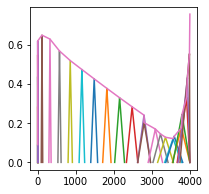

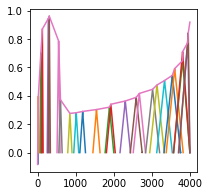

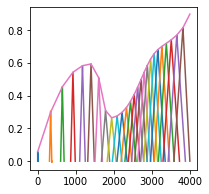

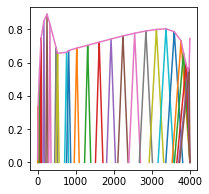

In [46]:
tt1 = time.perf_counter()

## CHOOSING 4 BEST FILTERBANKS FROM THE POPULATION 

best_fbank = 4
ind_sort = np.argsort(valid_accuracy[:,gen-1])
best4_ind = ind_sort[::-1][:4]                          ## select the last for ele. of ind_sort

ESFB=np.zeros((best_fbank,8))

for i in range(best_fbank):
    ESFB[i,:]=EA_population[best4_ind[i],:]
    
                          
accuracy_test=np.zeros(best_fbank)
yv_test=np.zeros((best_fbank,4))

for bfb in range(best_fbank):                             #cc=[y1, delta, sigma[0,fb], rho[0,fb]]+ y2_rand[fb,:].tolist()
    yv_test[bfb,1]=ESFB[bfb,0]                            # yv[fb][:]=[0,y1,y2,1]
    yv_test[bfb,2]=ESFB[bfb,0]+ESFB[bfb,1]

yv_test[:,3]=1
yv2_test=ESFB[:,4:]

for fb in range(best_fbank):
    
    # formation of spline 1
    y_spline1_t = splineinterpolation(xv,yv_test[fb,:],ESFB[fb,2], ESFB[fb,3])  


    #plot(xx_mod,y_spline1)  

    y_min_t = min(y_spline1_t)                      
    y_max_t = max(y_spline1_t)

    ## OPTIMAIZATION OF FITER FREQ. LOCATION 

    freq_t=np.zeros(nf+1)
    for i in range (nf+1):                                   # i = 1:nf+1                            
        freq_t[i] = (y_spline1_t[i]-y_min_t)*fs/ (2*(y_max_t-y_min_t))

    freq_t=np.sort(freq_t)

    ## OPTIMIZATION OF FILTER AMPLITUDE

    y2_mod_t = [0.2]+ yv2_test[fb,:].tolist()+[1]
    cs_t = pchip(x2_modified, y2_mod_t)
    y_spline2_t=cs_t(xx)               # xx consists nf+2 pts. including end points

    #plt.plot(x2_modified, y2_modified, 'o', label='data')
    #plt.plot(xx, cs(xx), label="S")



    maxi_t=0
    for i in range(nf-1):                                     #i=1:nf-1
        t=np.absolute(freq_t[i+2]-freq_t[i])
        if(t > maxi_t):
            maxi_t=t

    N=256
    col_t=math.ceil(maxi_t*N/fs)+10
    filters_t=np.zeros((26,col_t))

    BW_t=np.zeros(nf)
    for i in range (nf):                                         # i=1:nf
        BW_t[i]=6.23*pow(freq_t[i]/1000,2)+93.39*(freq_t[i]/1000)+28.52


    plt.figure(figsize=(3,3))
    #plt.subplot(2,2)
    
    for i in range (nf):                                               # i=1:nf
        yline1_t = []
        yline2_t = []

        ff1_t = freq_t[i]-BW_t[i]/2
        ff2_t = freq_t[i]+BW_t[i]/2
        if(ff1_t > 0):
            f1_t = np.arange(ff1_t, freq_t[i]+1, fs/N)                             #ff1:fs/N:freq(i)
        else:
            f1_t = np.arange(0, freq_t[i]+1, fs/N)                                                        #0:fs/N:freq[i]

        if(ff2_t > (fs/2)):
            f2_t = np.arange(freq_t[i],(fs/2)+1, fs/N)                         #freq(i):fs/N:(fs/2);
            freq_inter_t = np.intersect1d(f2_t, fs/2)
            if(len(freq_inter_t) == 0):
                f2_t = np.append(f2_t, fs/2)

        else:
            f2_t = np.arange(freq_t[i], ff2_t+1, fs/N)                                      #freq(i):fs/N:ff2;
            freq_inter_t = np.intersect1d(f2_t, ff2_t)
            if(len(freq_inter_t) == 0):
                f2_t = np.append(f2_t, ff2_t)


        if(freq_t[i] == 0 or freq_t[i] == fs/2):
            if(freq_t[i]==0):
                yline1_t.append(np.array([0]))
                yline2_t.append(-y_spline2_t[i]*(f2_t-ff2_t)/(ff2_t-freq_t[i]))
            else:
                yline1_t.append(-y_spline2_t[i]*(f1_t-ff1_t)/(ff1_t-freq_t[i]))
                yline2_t.append(np.array([0]))

        elif(ff1_t<0 and freq_t[i]!=0 and ff2_t <= fs/2 ):
            yline1_t.append(y_spline2_t[i]*f1_t / freq_t[i])
            yline2_t.append(-y_spline2_t[i]*(f2_t-ff2_t) / (ff2_t-freq_t[i]))

        elif(ff2_t > (fs/2) and freq_t[i] < (fs/2) and ff1_t > 0):
            yline1_t.append(-y_spline2_t[i]*(f1_t-ff1_t) / (ff1_t-freq_t[i]))
            yline2_t.append(-y_spline2_t[i]*(f2_t-(fs/2)) / ((fs/2)-freq_t[i]))
        else:
            yline1_t.append(-y_spline2_t[i]*(f1_t-ff1_t) / (ff1_t-freq_t[i]))
            yline2_t.append(-y_spline2_t[i]*(f2_t-ff2_t) / (ff2_t-freq_t[i]))


        L1_t = yline1_t[0].tolist()
        L2_t = yline2_t[0].tolist()
        yline_t = L1_t+L2_t

        k_len_t = len(yline_t)
        f_final_t = np.append(f1_t,f2_t)
        filters_t[i,0:k_len_t] = yline_t
        plt.plot(f_final_t, filters_t[i,0:k_len_t])             # filters(i,1:k_len)


    plt.plot(freq_t , y_spline2_t[0:-1])                  # y_spline2(1:end-1)
    
    X_set_train = np.zeros((N_data, feat_size))
    X_set_test = np.zeros((N_test, feat_size))
    feature_set = np.zeros((len(X_all), feat_size))
    
    """
    for i in range(N_data):

        # y_noisy,STD_n=AWGN(X_data[i],10)
        y_noisy_t = X_data[i]
        X_set_train[i,:] = Mfcc(y_noisy_t, fs, freq_t, filters_t)                       #extracting mfcc coeff.   
        
    for i in range(N_test):
        X_set_test[i,:] = Mfcc(X_test[i], fs, freq_t, filters_t)
    
    X_train_t, X_valid_t, Y_train_t, Y_valid_t = data_norm_and_split(X_set_train,Y_data)
    
    X_test_data = data_norm(X_set_test)
    Y_test_data = np.asarray(Y_test)

    Y_test_pred, acc = SVM_accuracy(X_train_t,X_test_data,Y_train_t,Y_test_data)
    accuracy_test[fb] = acc
    """
    for i in range(len(X_all)):
        feature_set[i] = Mfcc(X_pre_emp[i], fs, freq_t, filters_t)
    
    print(colored("The observation is made for the best filter bank {}".format (fb), 'red', 'on_grey'), "\n")
    parameter_tuning(feature_set, Y_all)
        
tt2 = time.perf_counter()
print(f'Finished in {(tt2-tt1)/60} minutes')


In [47]:
def parameter_tuning(feature_vect, Y_data):
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X = scaler.fit_transform(feature_vect)
    y = np.asarray(Y_data)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=27)
       
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
    
    grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv = 5)
    grid.fit(X_train,y_train)
    print("best_estimator :- ", grid.best_estimator_, "\n")

    grid_predictions = grid.predict(X_test)
    print("confusion_matrix :-" , confusion_matrix(y_test,grid_predictions))
    print("classification_report :-" , classification_report(y_test,grid_predictions))
    print("score:- " , grid.score(X_test,y_test),"\n")


    scores_best = {"True":[], "False": []}
    shuffs = [True, False]

    for shuff in shuffs:
        print(colored("The observation is made when shuffle is {}".format (shuff), 'red', 'on_grey'), "\n")
        """
        best_svc = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
            max_iter=-1, probability=False, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
        """
        best_svc = grid.best_estimator_

        # k-fold cross validation

        cv = KFold(n_splits=10, random_state=42, shuffle = shuff)
        for train_index, test_index in cv.split(X):

            #print("Train Index: ", train_index, "\n")
            #print("Test Index: ", test_index)

            X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
            best_svc.fit(X_train, y_train)
            if(shuff == True):
                scores_best["True"].append(best_svc.score(X_test, y_test))
            else:
                scores_best["False"].append(best_svc.score(X_test, y_test))

            print("\n ")
        
    #scores_best
    Score_shuff_true=scores_best["True"]
    Score_shuff_false = scores_best["False"]
    print("Score_shuff_true :- ", np.mean(Score_shuff_true))
    print("Score_shuff_false :- ", np.mean(Score_shuff_false))
    
    return Score_shuff_true, Score_shuff_false

In [31]:
accuracy_test

array([0.13385827, 0.18897638, 0.13385827, 0.11811024])

In [6]:
def SVM_accuracy(X_train,X_valid,Y_train,Y_valid):
    y_pred=[]
    accuracy=[]
    
    for kernel in ('linear', 'rbf', 'poly'):
        clf = SVC(kernel=kernel, gamma=10)
        clf.fit(X_train, Y_train)
        #print(clf.score(X_valid,Y_valid))
        
        accuracy.append(clf.score(X_valid,Y_valid))
        y_pred.append(clf.predict(X_valid))
    
    ## for confusion matrix
    #cm1 = ConfusionMatrix(actual_vector=Y_valid, predict_vector=y_pred[0])
    
    return y_pred[0], accuracy[0]                   # here we are returning o/p from linear kernel
    
    


cm1 = ConfusionMatrix(actual_vector=Y_valid, predict_vector=y_pred[0])
print(cm1)
#cm1.classes
#cm1.table

In [22]:
def data_norm(X_test):
    scaler = preprocessing.StandardScaler()
    Xt_trans = scaler.fit_transform(X_test)
    
    return X_test


In [23]:
def data_norm_and_split(X_set,Y_data):
    Xx = X_set
    yy = np.asarray(Y_data)

    X_t, X_v, y_t, y_v = train_test_split(Xx,yy,test_size=0.2,random_state=27)

    scaler = preprocessing.StandardScaler()
    Xt_trans = scaler.fit_transform(X_t)
    Xv_trans = scaler.fit_transform(X_v)
    
    return Xt_trans,Xv_trans,y_t,y_v


##### data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

##### fit scaler on training data
norm = MinMaxScaler().fit(X_train)

##### transform training data
X_train_norm = norm.transform(X_train)

##### transform testing dataabs
X_test_norm = norm.transform(X_test)

In [24]:
def Mfcc_noisysig(y_noisy, fs, freq, filters):
    
    frame_len = 0.03*fs                    # 30 ms frame length
    L = math.floor(len(y_noisy)/(0.75*frame_len))          #total no. of frame with 25% overlap
    N = 256                                #lenght of fft
    nf=26
    y_fft = np.zeros((N,L-1))
    energy = np.zeros(L-1)          
    for j in range(L-1):                #j = 0:L-2
        y_fft[:,j] = np.absolute(np.fft.fft(y_noisy[int(frame_len*0.75*j): int((frame_len*0.75)*j+frame_len)]*np.hamming(frame_len), N))
        energy[j]=sum(np.absolute(y_fft[:,j]*y_fft[:,j]))
        
    
    # EXTRACTING VOICED PARTS FROM SPEECH SIGNAL

    frame_energy=energy
    ind_count=0
    noisy_initial=np.zeros(N)
    z=1
    for q in range (L-1):                                    #q=1:L-1         
        if(energy[q]/frame_len < 0.2):
            #voiced_frame=[voiced_frame, y_fft[:,q+1];
            #frame_energy(j)=energy(q);
            #j=j+1;
            if(z<=3):
                noisy_initial=noisy_initial+(y_fft[:,q-ind_count])*(y_fft[:,q-ind_count])
                z=z+1
              
            #y_fft[:,q-ind_count]=[]                           # C = np.delete(C, 1, 1) delete second column of C
            y_fft=np.delete(y_fft,q-ind_count,1)
            frame_energy=np.delete(frame_energy,q-ind_count)        #frame_energy[q-ind_count]=[]
            ind_count=ind_count+1
    
    noisy_initial=noisy_initial/3     # estimating initial noise power spectrum
    lamda=0.97                       #forgetting factor
    s_t = np.zeros((N,len(frame_energy)))
    noisy_t = np.zeros((N,len(frame_energy)))
    
    s_t[:,0] = np.absolute(y_fft[:,0]*y_fft[:,0])
    noisy_t[:,0] = lamda*noisy_initial+(1-lamda)*s_t[:,0]
    
    for q in range (1,len(frame_energy)):                              # q=2:length(frame_energy)
        s_t[:,q]=np.absolute(y_fft[:,q]*y_fft[:,q])
        noisy_t[:,q]=lamda*noisy_t[:,q-1]+(1-lamda)*s_t[:,q]
    
    max_frame=max(frame_energy)
    min_frame=min(frame_energy)
    mean_frame=np.mean(frame_energy)
    
    #k1= length(voiced_frame(1,:))
    frame_no= len(y_fft[0,:])

    DCT_mat =np.zeros((frame_no,13))
    M=13                                   #13 point dct of a voiced frame signal
    for p in range (frame_no):        # p=1:frame_no                    
        E_spect=np.zeros(nf-3)              #filter bank energy passing through nf Mel-band pass filter
        E_noisy_spect=np.zeros(nf-3)        #output of nf Mel-scaled filter when estimated noise is passed 
                                                #through filter bank
        SNR=np.zeros(nf-3)
        entropy=np.zeros(nf-3)
        R=np.zeros(nf-3)
        zeta=np.zeros(nf-3)
        W=np.zeros(nf-3)
        for q in range(nf-3):          # q=1:nf-3
            rr=np.arange(math.floor(freq[q]*N/fs)+1,math.ceil(freq[q+2]*N/fs)+1,1)   # rows of voiced frames
            
           #spect[q]= log(np.dot(filters[q,1:len(rr)],np.absolute(y_fft[rr,p])))
            E_spect[q]= filters[q,0:len(rr)].dot(s_t[rr,p])
            E_noisy_spect[q]= filters[q,0:len(rr)].dot(noisy_t[rr,p])
            
            x=np.absolute(np.transpose(y_fft[rr,p]))
            for j in range (len(x)):                                    #j=1:length(x)
                x_pmf=x[j]/sum(x)
                entropy[q]=entropy[q]-x_pmf*math.log(x_pmf)
                
       
        #E_spect=np.where(E_spect==math.nan, 0, E_spect)
        #E_spect=np.where(E_spect==math.inf, 0, E_spect)
        for ee in range (len(E_spect)):
            if(E_spect[ee]==math.nan or E_spect[ee]==math.inf):
                E_spect[ee]=0
        
        ## sub-band wiener filtering
        
        tap=20              ## no. of taps of wiener filter
        Rxy=np.correlate(E_spect,E_spect-E_noisy_spect)
        Ry=np.correlate(E_spect,E_spect)
        m=round(len(Rxy)/2)
        Rxy=Rxy[m :m+tap-1]
        Ry=Ry[m:m+tap-1]
        R_Y=toeplitz(Ry)
        h=np.matmul(inv(R_Y),np.transpose(Rxy))             # Filter Coefficients
        E_SWF=np.convolve(E_spect,h)            # enhanced filterbank energy after mel sub-band wiener filtering
        
        ## Calculation of SNR and Entropy for mel sub-bands
        
        for i in range(nf-3):                                 #i=1:nf-3
            SNR[i]=np.sqrt(1+(E_SWF[i]/E_noisy_spect[i]))
            R[i]=SNR[i]/entropy[i]                       ## SNR to Entropy ratio for ith mel frequency sub-band
        
        np.nan_to_num(R,copy=False)          # converting nan to zero and inf to large finite no.
        mean_R=np.mean(R)
        sigma_R=np.sqrt(np.var(R))
        
        for i in range(nf-3):                            # i=1:nf-3
            zeta[i]=1-(1/(1+math.exp(-(R[i]-mean_R)/sigma_R)))  
            W[i]=1-math.exp(-R[i]/zeta[i])
            
        
        #log_ESF=[math.log1p(i) for i in E_SWF]
        E_SWF=np.absolute(E_SWF)
        for i in range (len(E_SWF)):
            if(E_SWF[i]!=0):
                E_SWF[i]=math.log(E_SWF[i])
            else:
                E_SWF[i]=0
            
        spect=W*E_SWF
        DCT_mat[p,:]=np.absolute(scipy.fftpack.dct(spect,n=M))
        
    delta=np.zeros((frame_no-2,13))
    delta_delta = np.zeros((frame_no-4,13))
    for i in range (1,frame_no-1):                                 # i=2:frame_no-1
        delta[i-1,:]=DCT_mat[i+1,:]-DCT_mat[i-1,:]
    
    for i in range (1,frame_no-3):                                  #i=2:frame_no-3
        delta_delta[i-1,:]=delta[i+1,:]-delta[i-1,:]
    

    mfcc_coeff = np.mean(DCT_mat,axis=0)
    delta_coeff = np.mean(delta,axis=0)
    delta_delta_coeff = np.mean(delta_delta,axis=0)
    
    ff1 = np.hstack((mfcc_coeff,delta_coeff,delta_delta_coeff))
    #ff2=np.concatenate(ff1,delta_delta_coeff,axis=1)
    ff1 = np.append(ff1,[mean_frame, min_frame, max_frame])

    f_vect = ff1
    
    ff3=mfcc_coeff
    np.append(ff3,[mean_frame, min_frame, max_frame])
    #f_vect=ff3
    
    return f_vect
#,E_spect,E_SWF,W,zeta,R
        
        

In [25]:
##code for mfcc of original signal
def Mfcc(y_noisy, fs, freq, filters):
    
    frame_len = 0.03*fs                    # 30 ms frame length
    L = math.floor(len(y_noisy)/(0.75*frame_len))          #total no. of frame with 25% overlap
    N = 256                                #lenght of fft
    nf=26
    y_fft = np.zeros((N,L-1))
    energy = np.zeros(L-1)          
    for j in range(L-1):                #j = 0:L-2
        y_fft[:,j] = np.absolute(np.fft.fft(y_noisy[int(frame_len*0.75*j): int((frame_len*0.75)*j+frame_len)]*np.hamming(frame_len), N))
        energy[j]=sum(np.absolute(y_fft[:,j]*y_fft[:,j]))
        
    
    # EXTRACTING VOICED PARTS FROM SPEECH SIGNAL

    frame_energy=energy
    ind_count=0
    for q in range (L-1):                                    #q=1:L-1         
        if(energy[q]/frame_len < 0.2):
            #voiced_frame=[voiced_frame, y_fft[:,q+1];
            #frame_energy(j)=energy(q);
            #j=j+1;
              
            #y_fft[:,q-ind_count]=[]                           # C = np.delete(C, 1, 1) delete second column of C
            y_fft=np.delete(y_fft,q-ind_count,1)
            frame_energy=np.delete(frame_energy,q-ind_count)        #frame_energy[q-ind_count]=[]
            ind_count=ind_count+1
    
    s_t = np.zeros((N,len(frame_energy)))    
    #s_t[:,0] = np.absolute(y_fft[:,0]*y_fft[:,0])
    #noisy_t[:,0] = lamda*noisy_initial+(1-lamda)*s_t[:,0]
    
    for q in range (len(frame_energy)):                              # q=2:length(frame_energy)
        s_t[:,q]=np.absolute(y_fft[:,q]*y_fft[:,q])
        #noisy_t[:,q]=lamda*noisy_t[:,q-1]+(1-lamda)*s_t[:,q]
    
    max_frame=max(frame_energy)
    min_frame=min(frame_energy)
    mean_frame=np.mean(frame_energy)
    
    #k1= length(voiced_frame(1,:))
    frame_no= len(y_fft[0,:])

    DCT_mat =np.zeros((frame_no,13))
    M=13                                   #13 point dct of a voiced frame signal
    for p in range (frame_no):        # p=1:frame_no                    
        E_spect=np.zeros(nf-3)              #filter bank energy passing through nf Mel-band pass filter
        #E_noisy_spect=np.zeros(nf-3)        #output of nf Mel-scaled filter when estimated noise is passed 
                                                #through filter bank
    
        for q in range(nf-3):          # q=1:nf-3
            rr=np.arange(math.floor(freq[q]*N/fs)+1,math.ceil(freq[q+2]*N/fs)+1,1)   # rows of voiced frames
            
           #spect[q]= log(np.dot(filters[q,1:len(rr)],np.absolute(y_fft[rr,p])))
            E_spect[q]= filters[q,0:len(rr)].dot(s_t[rr,p])
                
        for ee in range (len(E_spect)):
            if(E_spect[ee]==math.nan or E_spect[ee]==math.inf):
                E_spect[ee]=0
        
        for i in range (len(E_spect)):
            if(E_spect[i]!=0):
                 E_spect[i]=math.log(np.absolute(E_spect[i]))
            else:
                E_spect[i]=0
            
            
        DCT_mat[p,:]=np.absolute(scipy.fftpack.dct(E_spect,n=M))
            
    
    
    delta=np.zeros((frame_no-2,13))
    delta_delta = np.zeros((frame_no-4,13))
    for i in range (1,frame_no-1):                                 # i=2:frame_no-1
        delta[i-1,:]=DCT_mat[i+1,:]-DCT_mat[i-1,:]
    
    for i in range (1,frame_no-3):                                                           #i=2:frame_no-3
        delta_delta[i-1,:]=delta[i+1,:]-delta[i-1,:]
    

    mfcc_coeff=np.mean(DCT_mat,axis=0)
    delta_coeff=np.mean(delta,axis=0)
    delta_delta_coeff=np.mean(delta_delta,axis=0)
    
    ff1=np.hstack((mfcc_coeff,delta_coeff,delta_delta_coeff))
    #ff2=np.concatenate(ff1,delta_delta_coeff,axis=1)
    ff1=np.append(ff1,[mean_frame, min_frame, max_frame])

    f_vect=ff1
    
    ff3=mfcc_coeff
    np.append(ff3,[mean_frame, min_frame, max_frame])
    #f_vect=ff3
    
    return f_vect
#,E_spect,E_SWF,W,zeta,R
        
        

In [26]:
def splineinterpolation(xv,yv,yp1,ypn):

    y2=np.zeros(4)         #2nd derivative
    n=len(y2)
    u=np.zeros(n-1)
    
    if (yp1 > 0.99e99):
        y2[0]=0
        u[0]=0
    else:
        y2[0]=yp1
        u[0]=(3.0/(xv[1]-xv[0]))*((yv[1]-yv[0])/(xv[1]-xv[0]-yp1))
    

    for i in range(1,n-1):                          #i=2:n-1
        sig=(xv[i]-xv[i-1])/(xv[i+1]-xv[i-1])
        p=sig*y2[i-1]+2.0
        y2[i]=(sig-1.0)/p
        u[i]=(yv[i+1]-yv[i])/(xv[i+1]-xv[i]) - (yv[i]-yv[i-1])/(xv[i]-xv[i-1])
        u[i]=(6.0*u[i]/(xv[i+1]-xv[i-1])-sig*u[i-1])/p
    

    if(ypn > 0.99e99):
        qn=0
        un=0
    else:
        qn=0.5
        un=(3.0/(xv[n-1]-xv[n-2]))*(ypn-(yv[n-1]-yv[n-2])/(xv[n-1]-xv[n-2]))
    
    y2[n-1]=(un-qn*u[n-2])/(qn*y2[n-2]+1.0)
                                     
    for k in np.arange(n-2,-1,-1):                                        # k=n-1:-1:1
        y2[k]=y2[k]*y2[k+1]+u[k]
    

    nf=26
    jl=1
    klo=jl
    khi=jl+1
    xx=xv
    h=xx[khi]-xx[klo]
                                     
    #if(h==0) % throw warning
                                     
    x = np.linspace(0,1,nf+3)          # nf+1 points bt 0 & 1, excluding 0 & 1
    x=np.delete(x,[0])
    x=np.delete(x,[27])
                            
    y=np.zeros(nf+1)
    
    for i in range (nf+1):                                 # i=1:nf+1
        a=(xx[khi]-x[i])/h
        b=(x[i]-xx[klo])/h
        y[i]=a*yv[klo]+b*yv[khi]+((a*a*a-a)*y2[klo]+(b*b*b-b)*y2[khi])*(h*h)/6.0
        if(y[i]<0):
            y[i]=0
        if(y[i]>1):
            y[i]=1
        
    #x=[0,x,1];
    #y=[0,y,1];
    # plot(x,y);

    return y


In [27]:
def AWGN(signal,SNR):
   
    
     #RMS value of signal
    RMS_s=np.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=np.sqrt(RMS_s**2/(pow(10,SNR/20)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, len(signal))
    
    return noise,STD_n


def awgn(signal,SNR):
    
    # Set a target SNR
    target_snr_db = SNR
    x_watts=signal
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    return noise_volts

In [28]:
def Evolution(EA_population,accuracy,yv,g):
    import random
    total_fbank=30
    current_member = 1
    lamda=20                                                                #selecting lamda individuals from 30 chromosomes
    chromo_size=8
    mating_pool=np.zeros((total_fbank,chromo_size))
    val =max(accuracy[:,g])
    best_indx=accuracy[:,g].tolist().index(max(accuracy[:,g]))
    best_individual=EA_population[best_indx,:]                             # best individual out of 30 individuals
    mating_pool[0,:]=best_individual                                       #elitist strategy
    #qq=np.zeros(lamda-1)
    qq=[]
    while current_member <lamda:
        rand_ind=random.sample(range(total_fbank), 10)                     # picking 10 individuals randomly out of 30
        best=0
        counter=0
        for j in range(len(rand_ind)):
            if current_member==1 and accuracy[rand_ind[j],g] > best and rand_ind[j]!=best_indx:
                best= accuracy[rand_ind[j],g]
                counter=j
            elif current_member >1 and accuracy[rand_ind[j],g] > best and rand_ind[j]!=best_indx:
                inter=list(set(qq) & set(rand_ind))
                if not inter:
                    best=accuracy[rand_ind[j],g]
                    counter=j
                else:
                    continue
               
        if (counter>0):
            mating_pool[current_member,:]=EA_population[rand_ind[counter],:]
            qq.append(rand_ind[counter])
            current_member+=1
      
    ## ONE POINT CROSSOVER
      
    slt=np.random.permutation(20) 
    select=slt.tolist()
    select.remove(0) 
    kk=20
    total=list(range(0,30))
    r=list(set(total).difference(set(qq)))
    if best_indx in r:
        r.remove(best_indx)
    n=len(r)
    
    for q in range(0,18,2):
        prob_crr = np.random.random()
        if (prob_crr <= 0.9):
            point=random.randint(1,6)
            mating_pool[kk,:]=mating_pool[select[q],0:point].tolist() + mating_pool[select[q+1],point:].tolist()
                                 
        else:
            p=np.random.randint(n)
            prnt_idx=r[p]
            r.remove(prnt_idx)
            n=n-1
            mating_pool[kk,:]=EA_population[prnt_idx,:]
                                  
    ### MUTATION OPERATOR ###
        for zz in range(chromo_size):
            if np.random.random() <= 0.12 :                                     #mutation probability is 0.12
                mating_pool[kk,zz]=np.random.random()
              
             
        kk=kk+1
        if (kk==29):
            mating_pool[kk,:]=[mating_pool[19,i] + mating_pool[18,i] for i in range(len(mating_pool[19,:]))] 
            #mating_pool[kk,:]=mating_pool[19,:]mating_pool[18,:]      # making last mating population as the combi of 19th & 20th mating population
        
    EA_population=mating_pool
    
    ## PARAMETER UPDATION
    for ff in range(total_fbank): 
        ## spline1 parameter updation
        a1=0.1
        yv[ff,1]=EA_population[ff,0]
        if yv[ff,1]>=1:
            yv[ff,1]=a1+np.random.random()*(1-2*a1)                      # parameter to limit range of spline in bet. 0 & 1   
            EA_population[ff,0]=yv[ff,1]
                                  
        y2_temp=EA_population[ff,0]+EA_population[ff,1]
        if (y2_temp >1):
            delta_temp=np.random.random()*(1-a-yv[ff,1])
            y2_temp=delta_temp+yv[ff,1]
            EA_population[ff,1]=delta_temp
                                  
        yv[ff,2]=y2_temp
         
        ### spline2 parameter updation
        y2_rand[ff,:]=EA_population[ff,4:]
        for i in range(4):
            if y2_rand[ff,i]>1:
                y2_rand[ff,i]=np.random.random()
                EA_population[ff,i+4]=y2_rand[ff,i]
          
              
    
    return EA_population,yv,y2_rand
